In [199]:
import os
import email
import csv
from datetime import datetime
import pandas as pd
import warnings
from sklearn.exceptions import ConvergenceWarning
# Filter out ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# -----------------------------------------------------------------------------------------------------------------------

class EnronEmailExtraction:
    def __init__(self, path):
        self.path = path
        self.email_list = []
        self.data_list = []
    
    def load_email_list(self):
        if os.path.exists(self.path):
            for name in os.listdir(self.path):
                person_folder = os.path.join(self.path, name)
                for folder in os.listdir(person_folder):
                    email_folder = os.path.join(person_folder, folder)
                    if os.path.isdir(person_folder) and os.path.exists(email_folder) and os.path.isdir(email_folder):
                        for name in os.listdir(email_folder):
                            file_path = os.path.join(email_folder, name)
                            if os.path.isfile(file_path):
                                self.email_list.append(file_path)

    @staticmethod
    def extract_fields(mail_content, headers):
        data = []
        msg = email.message_from_string(mail_content)
        for header in headers:
            if header == 'Body':
                data.append(msg.get_payload(decode=True).decode().replace('\t',' ').replace('\n', ' '))
            elif msg[header]:
                data.append(msg[header].replace('\n', ' ').replace('\t', ' '))
            else:
                data.append(' ')

        return data

    @staticmethod
    def read_mail(mail_path):
        data = ''
        with open(mail_path, 'r') as f:
            data = f.read()
        return data

    def extract_emails(self, headers, start=None, end=None):
        _start, _end = 0, len(self.email_list)
        
        if start is not None:
            _start = start
        if end is not None:
            _end = end
            
        for mail_path in self.email_list[start: end]:
            print("Reading {}".format(mail_path))
            data = EnronEmailExtraction.read_mail(mail_path)
            self.data_list.append(EnronEmailExtraction.extract_fields(data, headers))
    
    # csv_file: exported file name
    # headers: a list of headers of the csv file
    # headers_format: dict {header: format_pattern} of the header columns
    def export_to_csv(self, csv_file_path, headers = ['From', 'To','Subject', 'Date', 'X-Folder', 'Body'], start=None, end=None):
        self.extract_emails(headers, start, end)
        with open(csv_file_path, 'w', newline='', encoding='utf-8') as f:
            csv_writer = csv.writer(f, delimiter='\t')
            csv_writer.writerow(headers)
            for row in self.data_list:
                csv_writer.writerow(row)\
                
# -------------------------------------------------------------------------------------------------------------------------

class SytheticEmailExtraction:
    def __init__(self, path, target):
        self.path = path
        self.data_list = []
        self.target = target

    @staticmethod
    def read_text(path):
        data = ''
        with open(path, 'r') as f:
            data = f.read()
        return data

    def extract_email(self):
        if os.path.exists(self.path):
            emails = SytheticEmailExtraction.read_text(self.path)
            emails_arr = emails.split("---")

            rows = []
            for email in emails_arr:
                row = []
                if email.strip():
                    split_data = email.strip().replace('\n\n','\n').strip().split('\n')
                    subject = split_data[0].split(":")[1].strip()
                    body = split_data[2:-2]
                    row.append(subject)
                    row.append(" ".join(body).replace('\t',' ').replace('\n', ' '))
                    row.append(self.target)
                    self.data_list.append(row)

    def export_to_csv(self, csv_file_path, headers=['Subject', 'Body', 'Targets']):
        with open(csv_file_path, 'w', newline='', encoding='utf-8') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(headers)
            for row in self.data_list:
                csv_writer.writerow(row)
                

In [200]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from imblearn.over_sampling import SMOTE
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

def hyperparameters_tuning(model, X, y, param_grid):
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

    # Perform grid search
    grid_search.fit(X, y)

    # Print the best hyperparameters found
    print("Best hyperparameters:", grid_search.best_params_)

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    train_accuracy = best_model.score(X_res, y_res)
    test_accuracy = best_model.score(X_test_bow, test_data['Target_Encode'])
    # Create confusion matrix
    y_pred = best_model.predict(X_test_bow)
    conf_matrix = confusion_matrix(test_data['Target_Encode'], y_pred)
    print('-------------------------------------------------------------------------------------------------------------')
    print("Train accuracy:", train_accuracy)
    print("Test accuracy:", test_accuracy)
    print('-------------------------------------------------------------------------------------------------------------')
    # Print classification report
    print(classification_report(test_data['Target_Encode'], y_pred, target_names=encoder.classes_))
    print('-------------------------------------------------------------------------------------------------------------')
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return grid_search.best_params_

def unique_words_count(text):
    words = text.split()
    return len(set(words))

def summarize_emails(data_df):
    total_document_length = data_df['Subject'].apply(lambda text: len(text)).sum()
    total_document_length += data_df['Body'].apply(lambda text: len(text)).sum()
    total_document = data_df.shape[0]
    unique_words = data_df['Subject'].apply(unique_words_count).sum()
    unique_words += data_df['Body'].apply(unique_words_count).sum()
                                                   
    print('Total Documents: ', total_document)
    print('Document Length: {} words'.format(total_document_length))
    print('Average Document Length: {} words'.format(total_document_length/total_document))
    print('Vocabulary Size: {} unique words'.format(unique_words))
    
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

def remove_punctuation(text):
    tokens = word_tokenize(text)
    tokens_without_punctuation = [token for token in tokens if token.isalnum()]
    return ' '.join(tokens_without_punctuation)

def remove_stopwords_and_punctuation(text):
    return remove_stopwords(remove_punctuation(text))

def perform_cross_validation_and_report(model, X, y):
    start = time.time()
    scoring = {
            'acc': 'accuracy',
            'f1_mac': 'f1_macro',
            'jacc_mac': 'jaccard_macro'
    }
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)
    training_time = (time.time() - start)
    print("accuracy: ", scores['test_acc'].mean())
    print("f1_score: ", scores['test_f1_mac'].mean())
    print("Jaccard_index: ", scores['test_jacc_mac'].mean())
    print("time (sec): ", training_time)
    print("\n") 

def perform_learning_curve_and_visualizarion(model, X, y):
    # Define the number of training examples to plot learning curve
    train_sizes = np.linspace(0.1, 1.0, 10)  # Use 10 different training sizes

    # Generate learning curve data
    train_sizes, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=train_sizes, cv=5)

    # Calculate mean and standard deviation of training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.1)
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='orange')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color='orange', alpha=0.1)
    plt.title('Learning Curve')
    plt.xlabel('Number of training examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# 1. Data Collection

### process enron email data

path = os.path.join('.', 'enron_mail_20150507', 'maildir')
csv_file_path = os.path.join('.', 'mails.csv')

enron = EnronEmailExtraction(path=path)
enron.load_email_list()
enron.export_to_csv(csv_file_path)

date_format = '%a, %d %b %Y %H:%M:%S %z'
folders = ['logistics', 'tw-commercial group', 'deal discrepancies', 'management', 'resumes', 'online trading']
df = pd.read_csv('mails.csv', delimiter='\t')
df['Date'] = df['Date'].apply(lambda d: datetime.strptime(d[:-6], date_format))
df['X-Folder'] = df['X-Folder'].fillna('')    
df['X-Folder'] = df['X-Folder'].apply(lambda folder: folder.split("\\")[-1].lower())
df_filter = df[df['X-Folder'].isin(folders)].copy()
mapping = {'resumes': 'HR', 'logistics': 'Shipping', 'tw-commercial group': 'Business', 'online trading': 'Sale'}
df_filter['Targets'] = df_filter['X-Folder'].map(mapping)
data.to_csv('enron_emails.csv', index=False)

In [ ]:
pd.read_csv('enron_emails.csv')

### Process synthetic email data

In [201]:
text_file_path1 = os.path.join('.', 'Finance_email.txt')

synthetic1 = SytheticEmailExtraction(text_file_path1, 'Finance')         
synthetic1.extract_email()
synthetic1.export_to_csv('finance_emails.csv', )

In [202]:
pd.read_csv('finance_emails.csv')

,Subject,Body,Targets
0,Clarification Needed on Incentive Program,I hope this email finds you well. I am writing...,Finance
1,Seeking Clarity on Incentive Program Details,I trust this email finds you well. I wanted to...,Finance
2,Questions Regarding Incentive Program Parameters,I hope you're doing well. I wanted to reach ou...,Finance
3,Inquiry Regarding Incentive Program Mechanics,I hope this email finds you well. I recently l...,Finance
4,Seeking Clarity on Incentive Program Guidelines,I trust this email finds you well. I am reachi...,Finance
...,...,...,...
588,Transparent Inquiry Regarding Company Trip Bud...,I hope you're doing well. As we plan for organ...,Finance
589,Exploring Sustainable Company Trip Options Wit...,I hope this email finds you well. As part of o...,Finance
590,Inquiring About Budget for Remote Company Trip...,I hope this email finds you well. With the ris...,Finance
591,Inquiry About Budget for Compliance Company Trip,I trust you're doing well. As we prioritize co...,Finance


In [203]:
text_file_path2 = os.path.join('.', 'IT_email.txt')

synthetic2 = SytheticEmailExtraction(text_file_path2, 'IT')         
synthetic2.extract_email()
synthetic2.export_to_csv('it_emails.csv')

In [204]:
pd.read_csv('it_emails.csv')

,Subject,Body,Targets
0,Critical System Failure,We regret to inform you that our system has en...,IT
1,Network Connectivity Issues,We're writing to inform you that our network i...,IT
2,Software Application Crash,We're reaching out to inform you about a criti...,IT
3,Server Hardware Failure,We regret to inform you that one of our server...,IT
4,Immediate Attention Required,I hope this email finds you well. Our system d...,IT
...,...,...,...
755,Urgent,I hope you're doing well. We're facing an urge...,IT
756,Error Message,I hope you're doing well. We're encountering a...,IT
757,Issue with Access Database,I trust you're having a good day. We're facing...,IT
758,Issue with Access Database,I hope this email finds you well. We're encoun...,IT


# 2. Data Exploration

#### Exploring enron email

In [205]:
csv_file_path = os.path.join('.', 'enron_emails.csv')
enron_df = pd.read_csv(csv_file_path)

In [206]:
enron_df.head()

,From,To,Subject,Date,X-Folder,Body,Targets
0,gay.mayeux@enron.com,sally.beck@enron.com,Opportunities,2001-04-19 12:01:00-07:00,resumes,"Sally, Thanks for taking the time to meet wit...",HR
1,gary.taylor@enron.com,"toni.graham@enron.com, sally.beck@enron.com",Resume - Jasmine Master Katrak,2000-08-18 06:05:00-07:00,resumes,Toni - Sally suggested I forward this resume ...,HR
2,tom.may@enron.com,sally.beck@enron.com,Resume for Margaret Dhont,2000-08-09 10:06:00-07:00,resumes,"Sally, As discussed, attached below is the re...",HR
3,grant.zimmerman@enron.com,sally.beck@enron.com,Re: Associates PRC Meeting,2000-07-21 04:12:00-07:00,resumes,Here's my resume for your review. Grant W. ...,HR
4,shelly.friesenhahn@enron.com,sally.beck@enron.com,Mid year review - resume,2000-07-20 04:14:00-07:00,resumes,"Sally, Per your request, here is a copy of my...",HR


In [207]:
enron_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3530 entries, 0 to 3529
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   From      3530 non-null   object
 1   To        3483 non-null   object
 2   Subject   3491 non-null   object
 3   Date      3530 non-null   object
 4   X-Folder  3530 non-null   object
 5   Body      3530 non-null   object
 6   Targets   3530 non-null   object
dtypes: object(7)
memory usage: 193.2+ KB


In [208]:
# Investigate three columns, which are going to use to build the model
enron_df[['Subject', 'Body', 'Targets']].isna().sum()

Subject    39
Body        0
Targets     0
dtype: int64

In [209]:
# There are only 39 NA rows, so just dropping them.
enron_df = enron_df.dropna()
enron_df[['Subject', 'Body', 'Targets']].isna().sum()

Subject    0
Body       0
Targets    0
dtype: int64

In [210]:
# converting all text to lowercase
enron_df['Subject'] = enron_df['Subject'].str.lower()
enron_df['Body'] = enron_df['Body'].str.lower()
enron_df['Targets'] = enron_df['Targets'].str.lower()
enron_df = enron_df[['Subject', 'Body', 'Targets']]

In [211]:
enron_df

,Subject,Body,Targets
0,opportunities,"sally, thanks for taking the time to meet wit...",hr
1,resume - jasmine master katrak,toni - sally suggested i forward this resume ...,hr
2,resume for margaret dhont,"sally, as discussed, attached below is the re...",hr
3,re: associates prc meeting,here's my resume for your review. grant w. ...,hr
4,mid year review - resume,"sally, per your request, here is a copy of my...",hr
...,...,...,...
3525,re: eta's,"bob, all latest etas (to my knowledge) are i...",sale
3526,re: eta's,please ensure that any online documents that a...,sale
3527,re: country/state of incorporation,i think jeff like myself has been out of the o...,sale
3528,legal issue - customer registration,"hi mark, this is an email that i recieved fro...",sale


#### Explore synthetic email data

In [212]:
csv_file_path = os.path.join('.', 'finance_emails.csv')
finance_df = pd.read_csv(csv_file_path)

In [213]:
finance_df.head()

,Subject,Body,Targets
0,Clarification Needed on Incentive Program,I hope this email finds you well. I am writing...,Finance
1,Seeking Clarity on Incentive Program Details,I trust this email finds you well. I wanted to...,Finance
2,Questions Regarding Incentive Program Parameters,I hope you're doing well. I wanted to reach ou...,Finance
3,Inquiry Regarding Incentive Program Mechanics,I hope this email finds you well. I recently l...,Finance
4,Seeking Clarity on Incentive Program Guidelines,I trust this email finds you well. I am reachi...,Finance


In [214]:
finance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  593 non-null    object
 1   Body     593 non-null    object
 2   Targets  593 non-null    object
dtypes: object(3)
memory usage: 14.0+ KB


In [215]:
finance_df[['Subject', 'Body', 'Targets']].isna().sum()

Subject    0
Body       0
Targets    0
dtype: int64

In [216]:
finance_df['Subject'] = finance_df['Subject'].str.lower()
finance_df['Body'] = finance_df['Body'].str.lower()
finance_df['Targets'] = finance_df['Targets'].str.lower()

In [217]:
finance_df

,Subject,Body,Targets
0,clarification needed on incentive program,i hope this email finds you well. i am writing...,finance
1,seeking clarity on incentive program details,i trust this email finds you well. i wanted to...,finance
2,questions regarding incentive program parameters,i hope you're doing well. i wanted to reach ou...,finance
3,inquiry regarding incentive program mechanics,i hope this email finds you well. i recently l...,finance
4,seeking clarity on incentive program guidelines,i trust this email finds you well. i am reachi...,finance
...,...,...,...
588,transparent inquiry regarding company trip bud...,i hope you're doing well. as we plan for organ...,finance
589,exploring sustainable company trip options wit...,i hope this email finds you well. as part of o...,finance
590,inquiring about budget for remote company trip...,i hope this email finds you well. with the ris...,finance
591,inquiry about budget for compliance company trip,i trust you're doing well. as we prioritize co...,finance


In [218]:
csv_file_path = os.path.join('.', 'it_emails.csv')
it_df = pd.read_csv(csv_file_path)

In [219]:
it_df.head()

,Subject,Body,Targets
0,Critical System Failure,We regret to inform you that our system has en...,IT
1,Network Connectivity Issues,We're writing to inform you that our network i...,IT
2,Software Application Crash,We're reaching out to inform you about a criti...,IT
3,Server Hardware Failure,We regret to inform you that one of our server...,IT
4,Immediate Attention Required,I hope this email finds you well. Our system d...,IT


In [220]:
it_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  760 non-null    object
 1   Body     760 non-null    object
 2   Targets  760 non-null    object
dtypes: object(3)
memory usage: 17.9+ KB


In [221]:
it_df[['Subject', 'Body', 'Targets']].isna().sum()

Subject    0
Body       0
Targets    0
dtype: int64

In [222]:
it_df['Subject'] = it_df['Subject'].str.lower()
it_df['Body'] = it_df['Body'].str.lower()
it_df['Targets'] = it_df['Targets'].str.lower()
it_df.head()

,Subject,Body,Targets
0,critical system failure,we regret to inform you that our system has en...,it
1,network connectivity issues,we're writing to inform you that our network i...,it
2,software application crash,we're reaching out to inform you about a criti...,it
3,server hardware failure,we regret to inform you that one of our server...,it
4,immediate attention required,i hope this email finds you well. our system d...,it


#### Concating enron_df, finance_df, it_df

In [223]:
data_df = pd.concat([enron_df, finance_df, it_df], axis=0)
data_df

,Subject,Body,Targets
0,opportunities,"sally, thanks for taking the time to meet wit...",hr
1,resume - jasmine master katrak,toni - sally suggested i forward this resume ...,hr
2,resume for margaret dhont,"sally, as discussed, attached below is the re...",hr
3,re: associates prc meeting,here's my resume for your review. grant w. ...,hr
4,mid year review - resume,"sally, per your request, here is a copy of my...",hr
...,...,...,...
755,urgent,i hope you're doing well. we're facing an urge...,it
756,error message,i hope you're doing well. we're encountering a...,it
757,issue with access database,i trust you're having a good day. we're facing...,it
758,issue with access database,i hope this email finds you well. we're encoun...,it


In [224]:
data_df.shape

(4797, 3)

# 3. Feature engineering

#### Email summary information before featurization

In [225]:
summarize_emails(data_df)

Total Documents:  4797
Document Length: 4478236 words
Average Document Length: 933.5493016468627 words
Vocabulary Size: 434069 unique words


In [226]:
data_df['Subject_Body'] = data_df['Subject'] + ' ' + data_df['Body']
data_df['Subject_Body'] = data_df['Subject_Body'].apply(remove_stopwords_and_punctuation)
summarize_emails(data_df)

Total Documents:  4797
Document Length: 4478236 words
Average Document Length: 933.5493016468627 words
Vocabulary Size: 434069 unique words


In [227]:
data_df

,Subject,Body,Targets,Subject_Body
0,opportunities,"sally, thanks for taking the time to meet wit...",hr,opportunities sally thanks taking time meet to...
1,resume - jasmine master katrak,toni - sally suggested i forward this resume ...,hr,resume jasmine master katrak toni sally sugges...
2,resume for margaret dhont,"sally, as discussed, attached below is the re...",hr,resume margaret dhont sally discussed attached...
3,re: associates prc meeting,here's my resume for your review. grant w. ...,hr,associates prc meeting resume review grant zim...
4,mid year review - resume,"sally, per your request, here is a copy of my...",hr,mid year review resume sally per request copy ...
...,...,...,...,...
755,urgent,i hope you're doing well. we're facing an urge...,it,urgent hope well facing urgent issue indexing ...
756,error message,i hope you're doing well. we're encountering a...,it,error message hope well encountering error mes...
757,issue with access database,i trust you're having a good day. we're facing...,it,issue access database trust good day facing ch...
758,issue with access database,i hope this email finds you well. we're encoun...,it,issue access database hope email finds well en...


In [228]:
encoder = LabelEncoder()
data_df['Target_Encode'] = encoder.fit_transform(data_df['Targets'])

In [229]:
encoder.classes_

array(['business', 'finance', 'hr', 'it', 'sale', 'shipping'],
      dtype=object)

In [230]:
data_df[['Target_Encode', 'Targets']].value_counts()

Target_Encode  Targets 
0              business    1146
5              shipping    1146
3              it           760
1              finance      593
2              hr           589
4              sale         563
Name: count, dtype: int64

In [231]:
data_df

,Subject,Body,Targets,Subject_Body,Target_Encode
0,opportunities,"sally, thanks for taking the time to meet wit...",hr,opportunities sally thanks taking time meet to...,2
1,resume - jasmine master katrak,toni - sally suggested i forward this resume ...,hr,resume jasmine master katrak toni sally sugges...,2
2,resume for margaret dhont,"sally, as discussed, attached below is the re...",hr,resume margaret dhont sally discussed attached...,2
3,re: associates prc meeting,here's my resume for your review. grant w. ...,hr,associates prc meeting resume review grant zim...,2
4,mid year review - resume,"sally, per your request, here is a copy of my...",hr,mid year review resume sally per request copy ...,2
...,...,...,...,...,...
755,urgent,i hope you're doing well. we're facing an urge...,it,urgent hope well facing urgent issue indexing ...,3
756,error message,i hope you're doing well. we're encountering a...,it,error message hope well encountering error mes...,3
757,issue with access database,i trust you're having a good day. we're facing...,it,issue access database trust good day facing ch...,3
758,issue with access database,i hope this email finds you well. we're encoun...,it,issue access database hope email finds well en...,3


In [232]:
data_df['Targets'].value_counts()

Targets
shipping    1146
business    1146
it           760
finance      593
hr           589
sale         563
Name: count, dtype: int64

In [233]:
train_data, test_data = train_test_split(data_df[['Subject_Body', 'Target_Encode']], random_state=100)

# 4. Data Transformation

In [234]:
start = time.time()
count_vectorizer = CountVectorizer()
bow_transform = CountVectorizer()
X_train_bow = bow_transform.fit_transform(train_data['Subject_Body'])
X_test_bow = bow_transform.transform(test_data['Subject_Body'])
end = time.time()
print("Execution time (sec): ",(end - start))

Execution time (sec):  0.742027759552002


In [235]:
X_train_bow.shape

(3597, 16114)

In [236]:
X_test_bow.shape

(1200, 16114)

In [237]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_bow, train_data['Target_Encode'])

In [238]:
y_res.value_counts()

Target_Encode
2    863
3    863
1    863
0    863
5    863
4    863
Name: count, dtype: int64

In [239]:
X_res.shape

(5178, 16114)

# 5. Cross validation and model selection

#### MultinomialNB algorithm

In [240]:
model = MultinomialNB()
perform_cross_validation_and_report(model, X_res, y_res)

accuracy:  0.9721862234905713
f1_score:  0.9721774276578958
Jaccard_index:  0.9466438670209776
time (sec):  0.14838480949401855




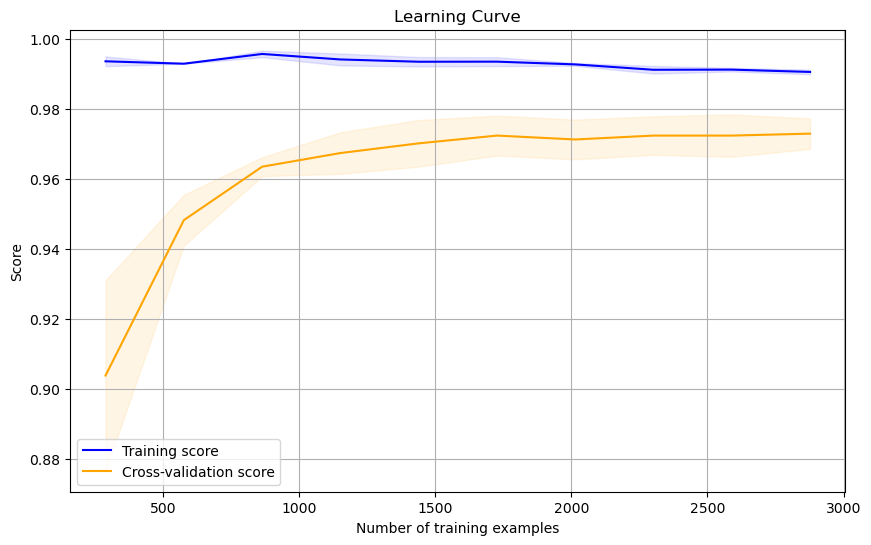

In [241]:
# Initialize MultinomialNB classifier
model = MultinomialNB()

perform_learning_curve_and_visualizarion(model, X_train_bow, train_data['Target_Encode'])

Best hyperparameters: {'alpha': 0.1, 'fit_prior': True}
-------------------------------------------------------------------------------------------------------------
Train accuracy: 0.9874468906913866
Test accuracy: 0.9783333333333334
-------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    business       0.97      0.99      0.98       283
     finance       1.00      1.00      1.00       160
          hr       0.95      0.99      0.97       141
          it       1.00      1.00      1.00       188
        sale       0.96      0.99      0.97       145
    shipping       0.99      0.94      0.96       283

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200

-------------------------------------------------------------------------------------------------------------


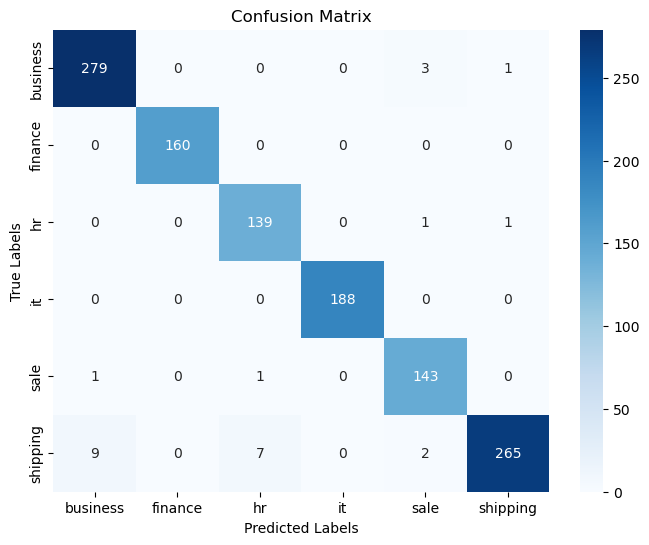

In [242]:
# Initialize MultinomialNB classifier
model = MultinomialNB()

# Define hyperparameters grid to search
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0],
    'fit_prior': [True, False]
}

best_param = hyperparameters_tuning(model, X_res, y_res, param_grid)

#### LinearSVC algorithm

In [243]:
model =  LinearSVC(dual='auto', max_iter=9000)

perform_cross_validation_and_report(model, X_res, y_res)

accuracy:  0.9555816686251468
f1_score:  0.9554632530118333
Jaccard_index:  0.916443879633758
time (sec):  6.081887245178223




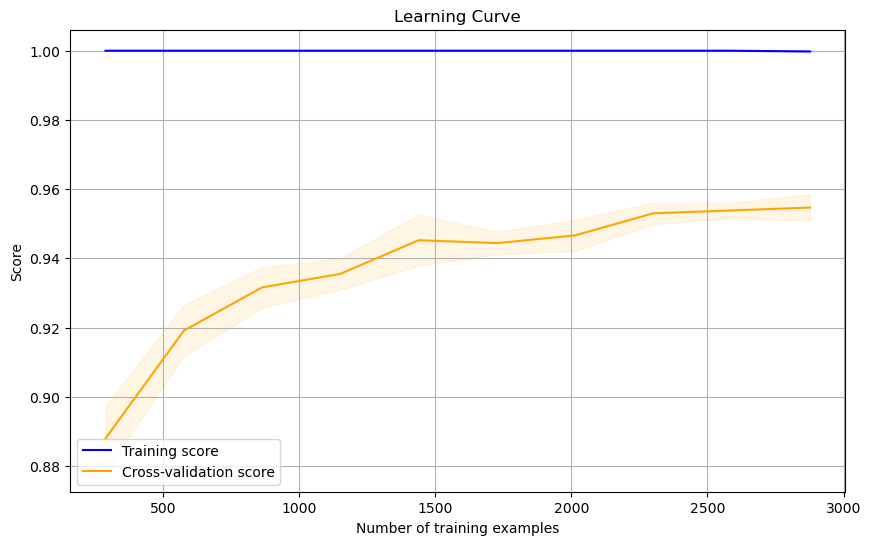

In [244]:
# Initialize LinearSVC classifier
model = LinearSVC(dual='auto')

perform_learning_curve_and_visualizarion(model, X_train_bow, train_data['Target_Encode'])

Best hyperparameters: {'C': 0.01, 'penalty': 'l2'}
-------------------------------------------------------------------------------------------------------------
Train accuracy: 0.9922750096562379
Test accuracy: 0.9575
-------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    business       0.96      0.94      0.95       283
     finance       1.00      1.00      1.00       160
          hr       0.96      0.96      0.96       141
          it       0.99      1.00      1.00       188
        sale       0.89      0.98      0.93       145
    shipping       0.95      0.92      0.93       283

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200

-------------------------------------------------------------------------------------------------------------


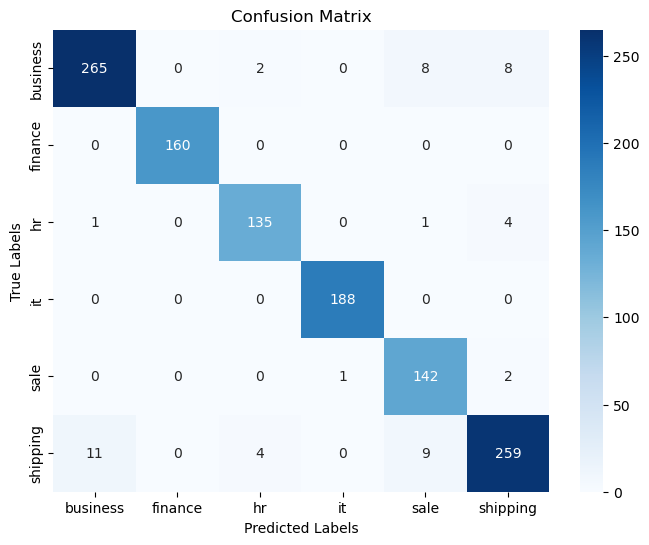

In [245]:
# Initialize MLPClassifier classifier
svc = LinearSVC(dual='auto')

# Define hyperparameters grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

best_param = hyperparameters_tuning(svc, X_res, y_res, param_grid)